**Лабораторная работа №3. Выполнил Полыгалов Богдан ПИ-20-2**

Задание:
1. Выбрать две группы ВК для исследования (более 1000 подписчиков). Проанализировать данные об их подписчиках (возраст, пол и т.д.). (4 балла)
2. Разработать методику сравнения групп между собой (пересечение пользователей, регион и т.д.). (3 балла)
3. Визуализировать граф пользователей групп из задания 1. (3 балла)
  * https://networkx.org/
  * https://habr.com/ru/companies/leader-id/articles/477976/

# Установка библиотек

In [ ]:
pip install vk_api

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.6/48.6 kB 1.5 MB/s eta 0:00:00


In [ ]:
pip install matplotlib seaborn

# Получение данных через API VK

Шаги для работы с API:
1. Регистрируемся в VK
2. Создаём приложение в качестве разработчика
3. В настройках созданного приложения получаем "Сервисный ключ доступа"

In [ ]:
import vk_api
import time
import pandas as pd

In [ ]:
# Нужно заменить YOUR_ACCESS_TOKEN на сервисный ключ доступ
access_token = 'YOUR_ACCESS_TOKEN'

# Создание объекта API, через него будем делать запросы
vk_session = vk_api.VkApi(token=access_token)
vk = vk_session.get_api()

Для получения участников групп будем использовать метод:
https://dev.vk.com/ru/method/groups.getMembers, <br>к сожалению, у этого метода есть ограничения:
* он не может вернуть больше 1000 участников
* можно выполнять только 1 запрос в секунду


Также изучим методы:
* https://dev.vk.com/ru/method/account.getProfileInfo
* https://dev.vk.com/ru/method/wall.get

так как в них описаны значения полей, которые мы будем получать

In [ ]:
# Метод для получения всех участников группы
def get_group_members_with_delay(group_id, total_count):
    members = []

    offset = 0
    while offset <= total_count:
        # Выполняем запрос
        response = vk.groups.getMembers(group_id=group_id, sort='id_asc', count=1000, offset=offset, fields=['sex', 'bdate', 'city', 'country'])
        members += response['items']

        # Увеличиваем сдвиг
        offset += 1000

        # Пауза на одну секунду перед следующим запросом
        time.sleep(1)

    return members

Изучаем следующие группы:
* https://vk.com/jettrec, музыкант и блогер, 265000 подписчиков
* https://vk.com/vk_stadium, концертная площадка в Москве / стадион, 54000 подписчиков. На ней часто выступают разные музыканты, в том числе CMH, группу которого мы тоже взяли

In [ ]:
# Указываем id групп и их количество
group_id_1 = 'vk_stadium'
total_count_1 = 54000
group_id_2 = 'jettrec'
total_count_2 = 265000

# Получаем список участников для каждой группы
followers_1 = get_group_members_with_delay(group_id=group_id_1, total_count=total_count_1)
followers_2 = get_group_members_with_delay(group_id=group_id_2, total_count=total_count_2)

# Преобразовываем данные в DataFrame, чтобы в дальнейшем обрабатывать
df_followers_1 = pd.DataFrame(followers_1)
df_followers_2 = pd.DataFrame(followers_2)

# Обработка данных

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx

In [ ]:
# Посмотрим какие колонки у нас есть
print(df_followers_1.columns.tolist())

['id', 'bdate', 'city', 'country', 'sex', 'first_name', 'last_name', 'can_access_closed', 'is_closed', 'deactivated']


In [ ]:
df_followers_1['text_sex'] = df_followers_1['sex'].replace({0: 'Не указан', 1: 'Женский', 2: 'Мужской'})
df_followers_2['text_sex'] = df_followers_2['sex'].replace({0: 'Не указан', 1: 'Женский', 2: 'Мужской'})

In [ ]:
# 1. Демографический анализ обеих групп
# Пол
sex_distribution_stadium = df_followers_1['text_sex'].value_counts()
sex_distribution_cmh = df_followers_2['text_sex'].value_counts()

# Возраст
df_followers_1['birth_date'] = pd.to_datetime(df_followers_1['bdate'], errors='coerce', format='%d.%m.%Y')
df_followers_2['birth_date'] = pd.to_datetime(df_followers_2['bdate'], errors='coerce', format='%d.%m.%Y')

# Фильтрация строк с датой рождения младше 1970 года
df_followers_1_filtered = df_followers_1[df_followers_1['birth_date'].dt.year >= 1970]
df_followers_2_filtered = df_followers_2[df_followers_2['birth_date'].dt.year >= 1970]

# Подсчет среднего возраста
average_age_stadium = (pd.Timestamp.now() - df_followers_1_filtered['birth_date']).mean().days // 365
average_age_cmh = (pd.Timestamp.now() - df_followers_2_filtered['birth_date']).mean().days // 365

# Страны и города
top_countries_stadium = df_followers_1['country'].apply(lambda x: x['title'] if pd.notna(x) else x).value_counts().head()
top_cities_stadium = df_followers_1['city'].apply(lambda x: x['title'] if pd.notna(x) else x).value_counts().head()

top_countries_cmh = df_followers_2['country'].apply(lambda x: x['title'] if pd.notna(x) else x).value_counts().head()
top_cities_cmh = df_followers_2['city'].apply(lambda x: x['title'] if pd.notna(x) else x).value_counts().head()


# 2. Анализ пересечения
# Возьмём строки, где одинаковый id пользователя, из обеих таблиц
common_members_info = pd.merge(df_followers_1, df_followers_2, on='id', suffixes=('_stadium', '_cmh'))
common_members_count = len(common_members_info['id'])

# Выборем нужные для анализа столбцы
result_columns = ['id', 'city_stadium', 'sex_stadium', 'birth_date_stadium', 'country_stadium']
common_members_info = common_members_info[result_columns]

# Пол
sex_distribution_common = common_members_info['sex_stadium'].replace({0: 'Не указан', 1: 'Женский', 2: 'Мужской'}).value_counts()

# Возраст
common_members_info['birth_date'] = pd.to_datetime(common_members_info['birth_date_stadium'], errors='coerce', format='%d.%m.%Y')

# Фильтрация строк с датой рождения младше 1970 года
common_members_info_filtered = common_members_info[common_members_info['birth_date'].dt.year >= 1970]

# Подсчет среднего возраста
average_age_common = (pd.Timestamp.now() - common_members_info_filtered['birth_date']).mean().days // 365

# Страны и города
top_countries_common = common_members_info['country_stadium'].apply(lambda x: x['title'] if pd.notna(x) else x).value_counts().head()
top_cities_common = common_members_info['city_stadium'].apply(lambda x: x['title'] if pd.notna(x) else x).value_counts().head()

In [ ]:
# Текстовый вывод результатов
print("1. Демографический анализ:")
print("Распределение по полу VK Stadium:")
print(sex_distribution_stadium)
print("\nРаспределение по полу CMH:")
print(sex_distribution_cmh)
print("\nСредний возраст VK Stadium:", average_age_stadium)
print("Средний возраст CMH:", average_age_cmh)
print("\nТоп стран VK Stadium:")
print(top_countries_stadium)
print("\nТоп городов VK Stadium:")
print(top_cities_stadium)
print("\nТоп стран CMH:")
print(top_countries_cmh)
print("\nТоп городов CMH:")
print(top_cities_cmh)


print("\n\n2. Анализ пересечения:")
print("Количество участников, которые есть в обеих группах:", common_members_count)
print("\nРаспределение по полу:")
print(sex_distribution_common)
print("\nСредний возраст:", average_age_common)
print("\nТоп стран:")
print(top_countries_common)
print("\nТоп городов:")
print(top_cities_common)

1. Демографический анализ:
Распределение по полу VK Stadium:
Мужской      27588
Женский      25595
Не указан        9
Name: text_sex, dtype: int64

Распределение по полу CMH:
Мужской      146388
Женский      118099
Не указан        41
Name: text_sex, dtype: int64

Средний возраст VK Stadium: 30
Средний возраст CMH: 22

Топ стран VK Stadium:
Russia        32792
Ukraine        2563
Belarus         488
USA             434
Kazakhstan      248
Name: country, dtype: int64

Топ городов VK Stadium:
Moscow              19121
Saint Petersburg     1973
Kyiv                  682
Nizhny Novgorod       349
Yekaterinburg         296
Name: city, dtype: int64

Топ стран CMH:
Russia        126691
Ukraine         7696
USA             4384
Belarus         3959
Kazakhstan      3511
Name: country, dtype: int64

Топ городов CMH:
Moscow              19833
Saint Petersburg    13306
Yekaterinburg        2964
Novosibirsk          2728
Krasnodar            1957
Name: city, dtype: int64


2. Анализ пересечения:
Ко

# Визуализация данных

## Сравнение двух групп

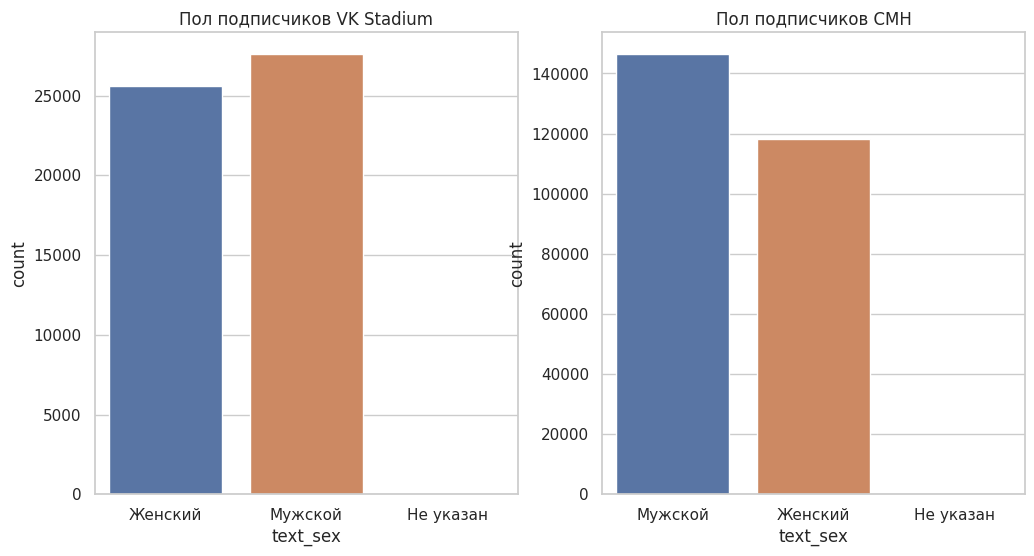

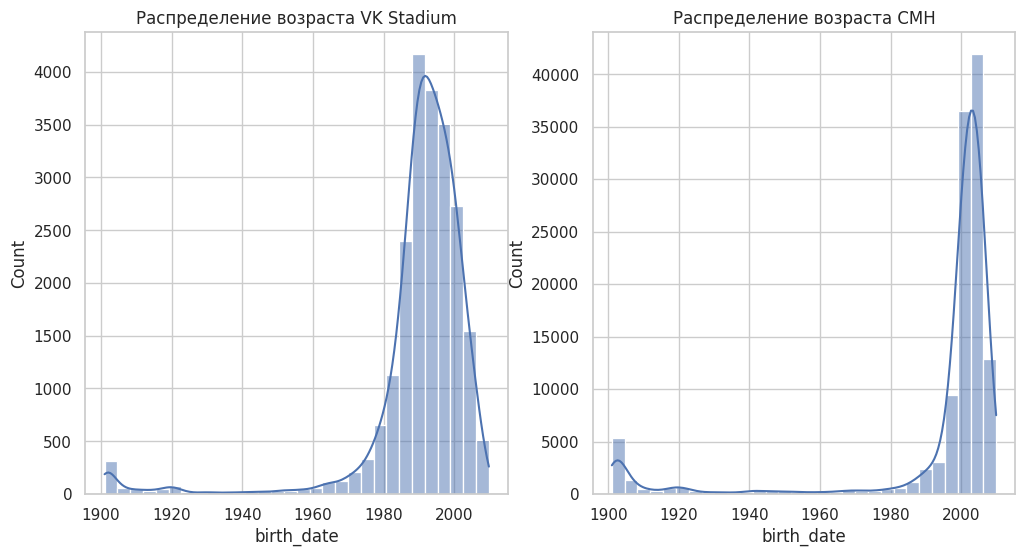

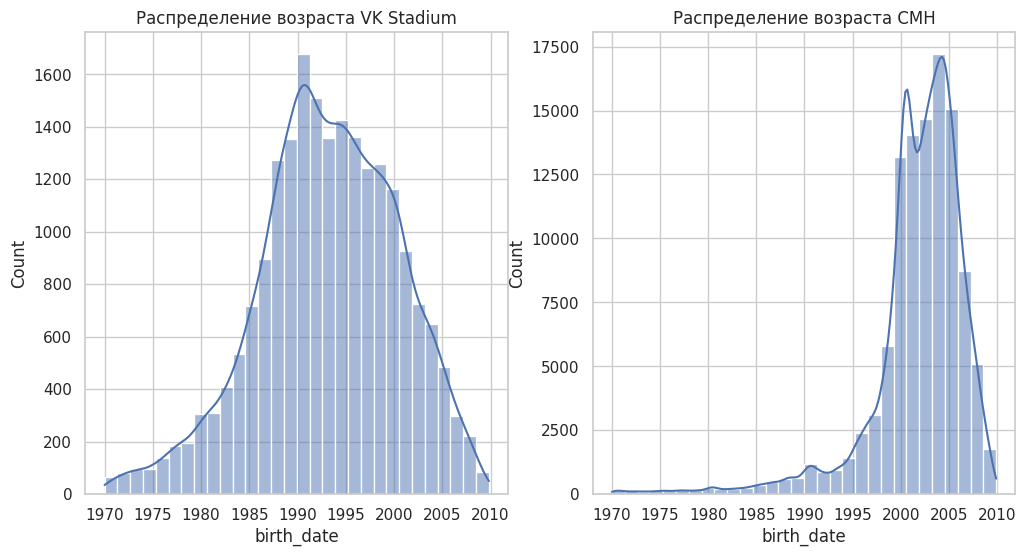

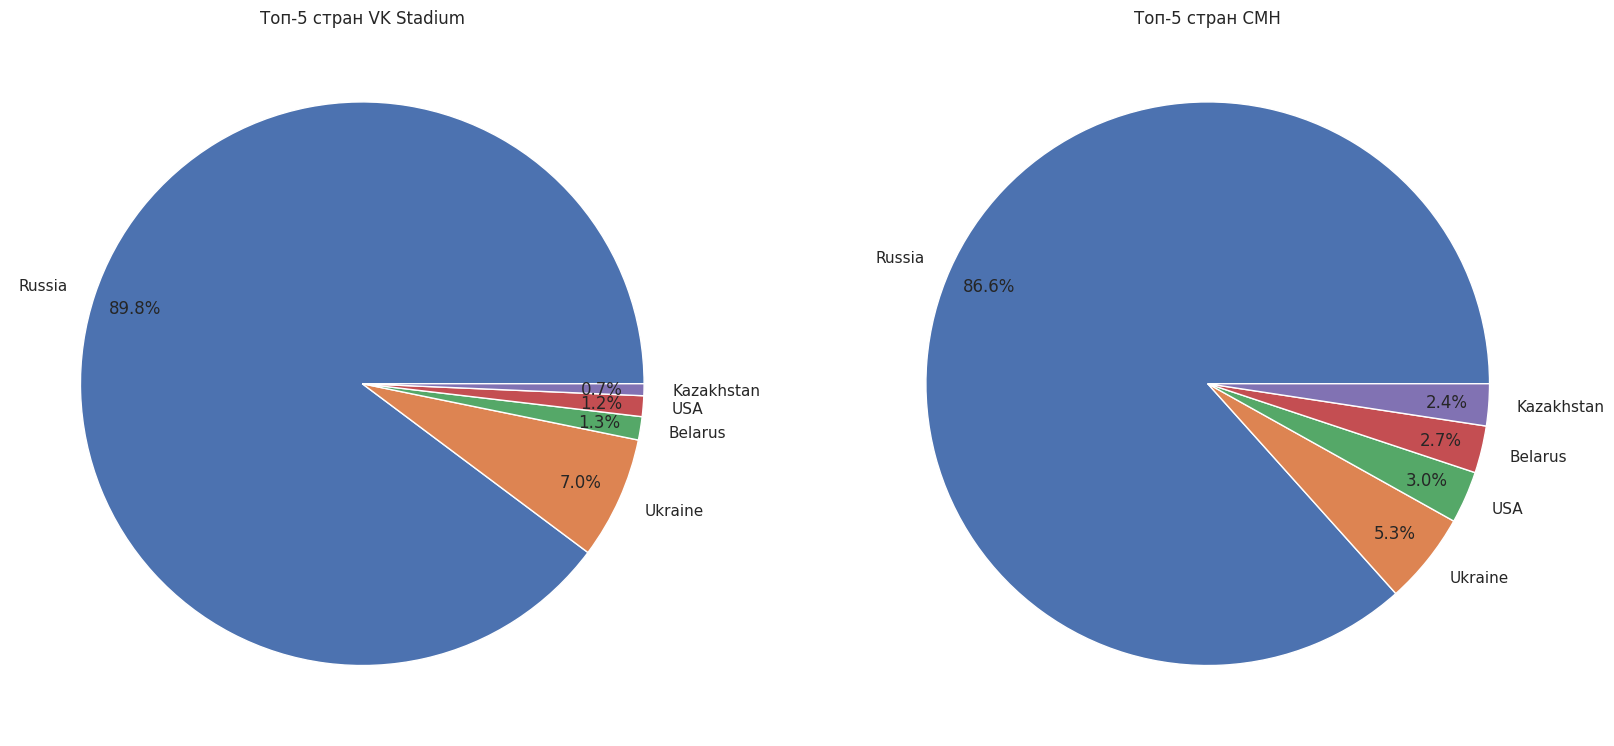

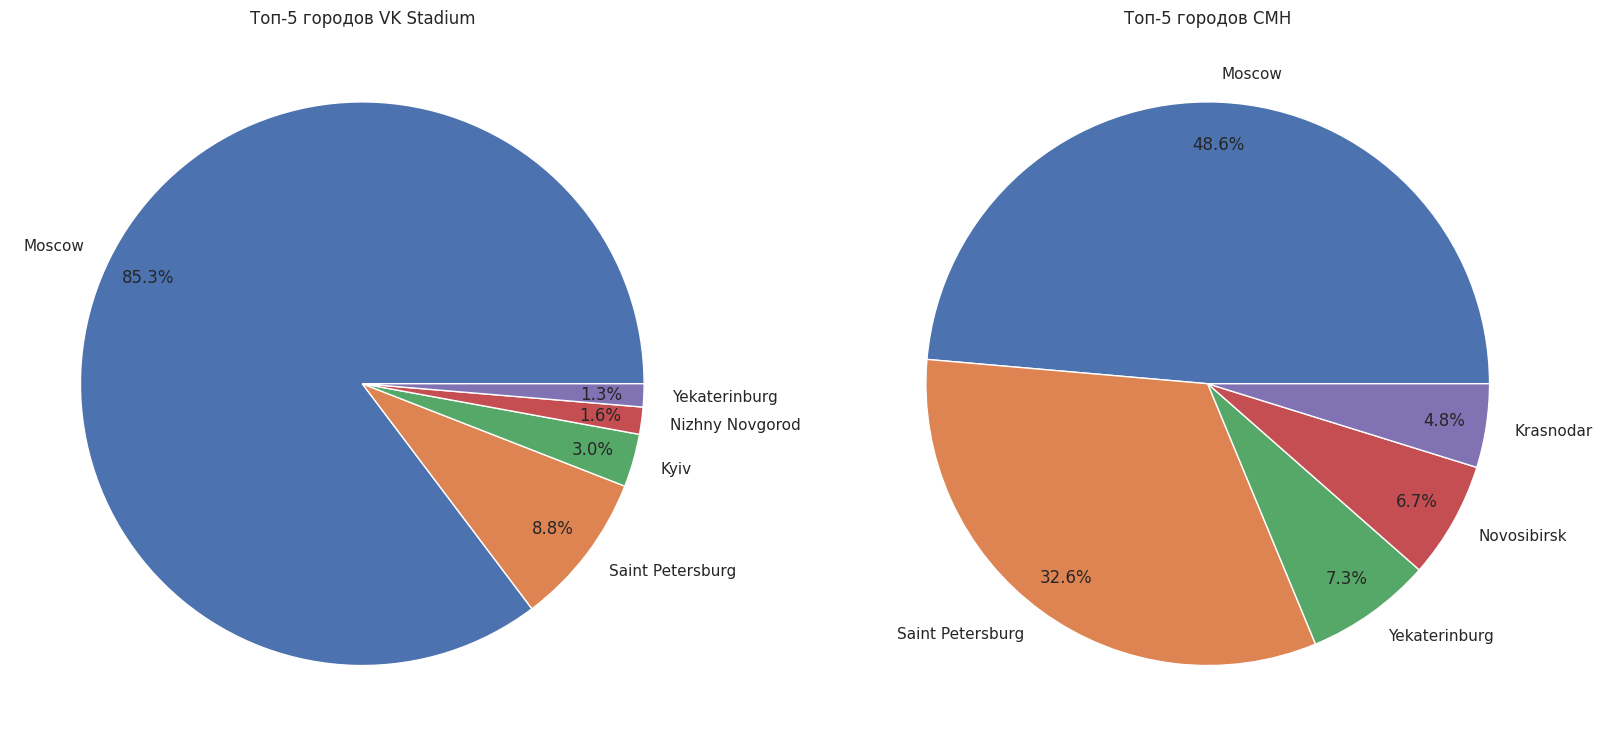

In [ ]:
# Установка стилей seaborn
sns.set(style="whitegrid")

# 1. Визуализация распределения по полу
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.countplot(x='text_sex', data=df_followers_1)
plt.title('Пол подписчиков VK Stadium')

plt.subplot(1, 2, 2)
sns.countplot(x='text_sex', data=df_followers_2)
plt.title('Пол подписчиков CMH')

plt.show()

# 2. Визуализация распределения возраста c младше 1970
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.histplot(df_followers_1['birth_date'].dropna(), bins=30, kde=True)
plt.title('Распределение возраста VK Stadium')

plt.subplot(1, 2, 2)
sns.histplot(df_followers_2['birth_date'].dropna(), bins=30, kde=True)
plt.title('Распределение возраста CMH')

plt.show()

# 3. Визуализация распределения возраста старше 1907
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.histplot(df_followers_1_filtered['birth_date'].dropna(), bins=30, kde=True)
plt.title('Распределение возраста VK Stadium')

plt.subplot(1, 2, 2)
sns.histplot(df_followers_2_filtered['birth_date'].dropna(), bins=30, kde=True)
plt.title('Распределение возраста CMH')

plt.show()

# 4. Топ-5 стран
plt.figure(figsize=(20, 10))

plt.subplot(1, 2, 1)
top_countries_stadium = df_followers_1['country'].apply(lambda x: x['title'] if pd.notna(x) else x).value_counts().head()
plt.pie(top_countries_stadium, labels=top_countries_stadium.index, autopct='%1.1f%%', pctdistance=0.85, startangle=1800)
plt.title('Топ-5 стран VK Stadium')

plt.subplot(1, 2, 2)
top_countries_cmh = df_followers_2['country'].apply(lambda x: x['title'] if pd.notna(x) else x).value_counts().head()
plt.pie(top_countries_cmh, labels=top_countries_cmh.index, autopct='%1.1f%%', pctdistance=0.85, startangle=1800)
plt.title('Топ-5 стран CMH')

plt.show()

# 5. Топ-5 городов
plt.figure(figsize=(20, 10))

plt.subplot(1, 2, 1)
top_cities_stadium = df_followers_1['city'].apply(lambda x: x['title'] if pd.notna(x) else x).value_counts().head()
plt.pie(top_cities_stadium, labels=top_cities_stadium.index, autopct='%1.1f%%', pctdistance=0.85, startangle=1800)
plt.title('Топ-5 городов VK Stadium')

plt.subplot(1, 2, 2)
top_cities_cmh = df_followers_2['city'].apply(lambda x: x['title'] if pd.notna(x) else x).value_counts().head()
plt.pie(top_cities_cmh, labels=top_cities_cmh.index, autopct='%1.1f%%', pctdistance=0.85, startangle=1800)
plt.title('Топ-5 городов CMH')

plt.show()

## Общие подписчики

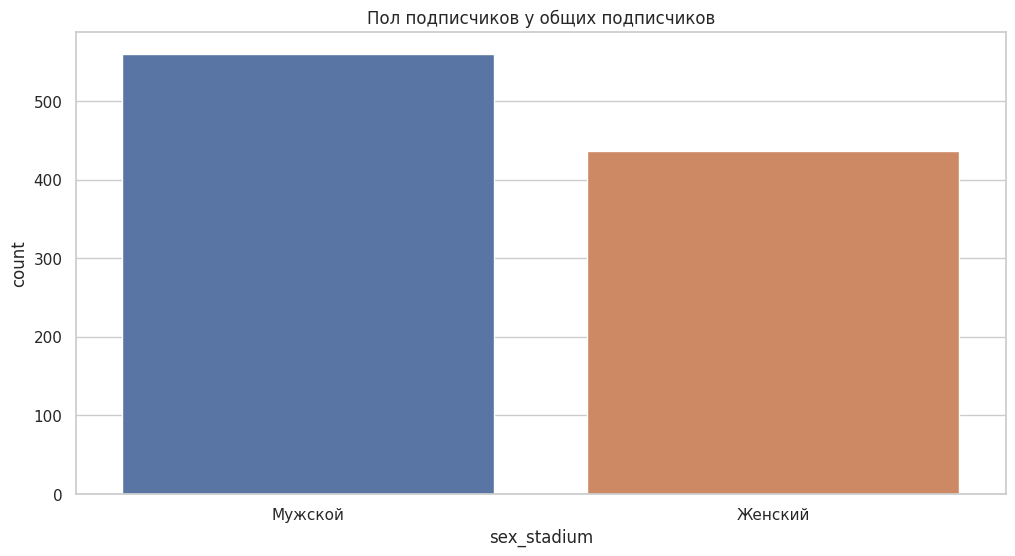

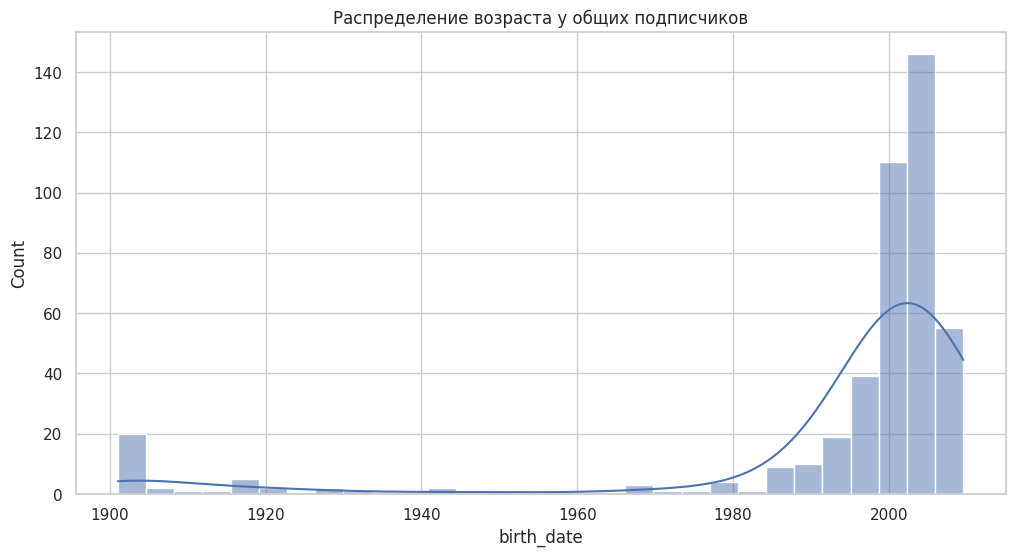

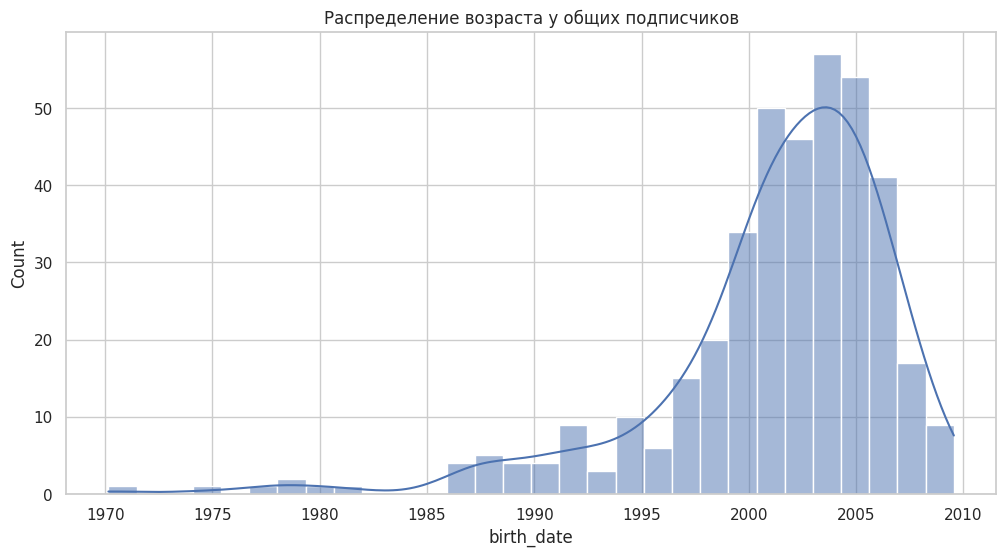

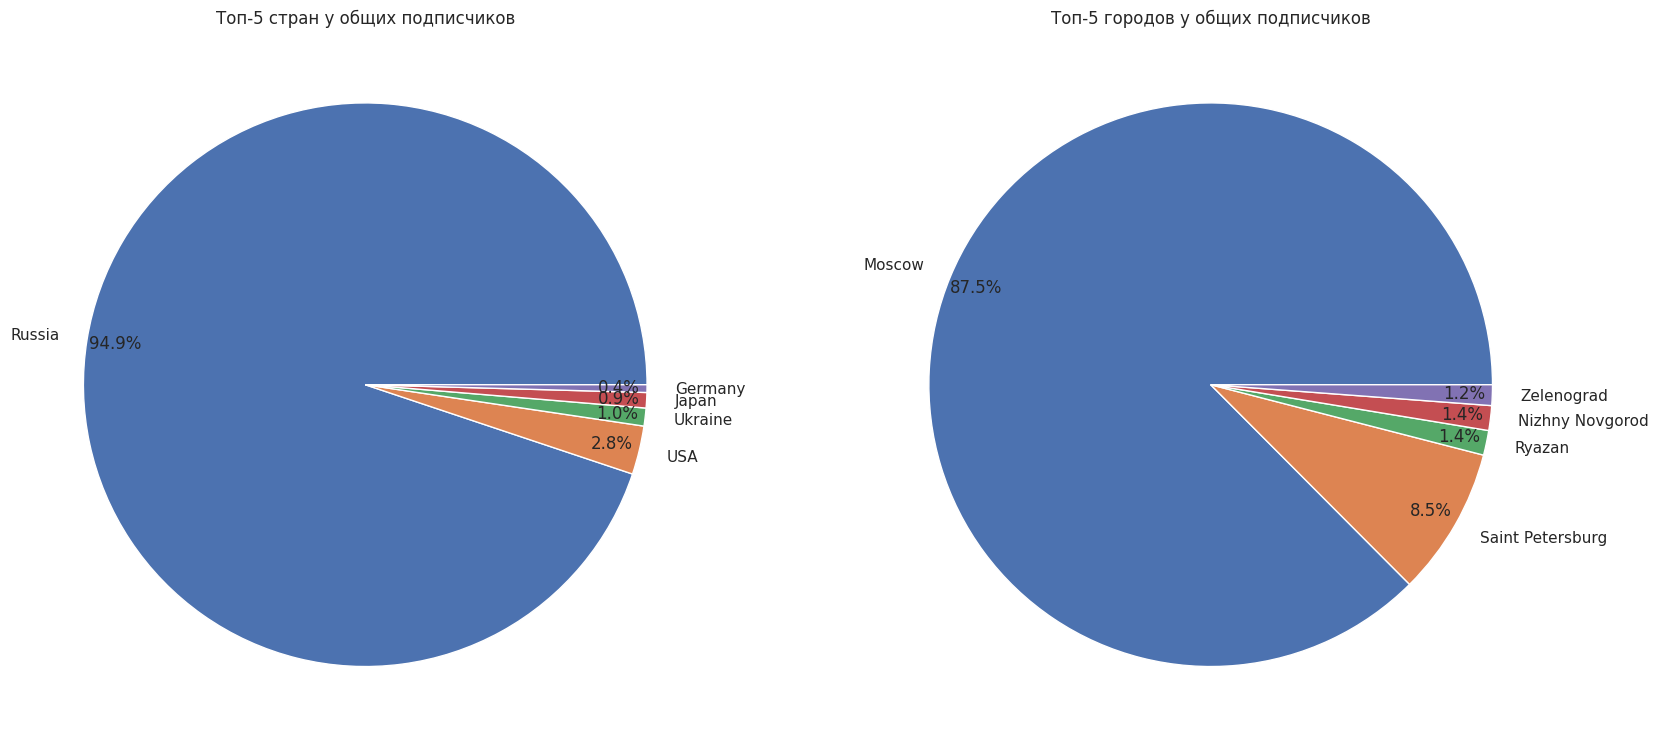

In [ ]:
# 1. Визуализация распределения по полу
plt.figure(figsize=(12, 6))

sns.countplot(x='sex_stadium', data=common_members_info.replace({0: 'Не указан', 1: 'Женский', 2: 'Мужской'}))
plt.title('Пол подписчиков у общих подписчиков')

plt.show()

# 2. Визуализация распределения возраста c младше 1970
plt.figure(figsize=(12, 6))

sns.histplot(common_members_info['birth_date'].dropna(), bins=30, kde=True)
plt.title('Распределение возраста у общих подписчиков')

plt.show()

# 3. Визуализация распределения возраста старше 1970
plt.figure(figsize=(12, 6))

sns.histplot(common_members_info_filtered['birth_date'].dropna(), bins=30, kde=True)
plt.title('Распределение возраста у общих подписчиков')

plt.show()

# 4. Топ-5 стран
plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)

top_countries_stadium = common_members_info['country_stadium'].apply(lambda x: x['title'] if pd.notna(x) else x).value_counts().head()
plt.pie(top_countries_stadium, labels=top_countries_stadium.index, autopct='%1.1f%%', pctdistance=0.9, startangle=1800)
plt.title('Топ-5 стран у общих подписчиков')

# 5. Топ-5 городов

plt.subplot(1, 2, 2)

top_cities_stadium = common_members_info['city_stadium'].apply(lambda x: x['title'] if pd.notna(x) else x).value_counts().head()
plt.pie(top_cities_stadium, labels=top_cities_stadium.index, autopct='%1.1f%%', pctdistance=0.9, startangle=1800)
plt.title('Топ-5 городов у общих подписчиков')

plt.show()

## Граф

In [ ]:
# Ограничение по пользователям из каждой группы
df_followers_1_subset = df_followers_1 .head(600)
df_followers_2_subset = df_followers_2 .head(600)
common_members_info_subset = common_members_info .head(600)

# Создание пустого графа
G = nx.Graph()

# Добавление узлов (пользователей) из обеих групп
G.add_nodes_from(["stadium"], group='stadium')
G.add_nodes_from(["cmh"], group='cmh')

G.add_nodes_from(df_followers_1_subset['id'], group='stadium_subs')
G.add_nodes_from(df_followers_2_subset['id'], group='cmh_subs')

common_user_ids = common_members_info_subset['id']
common_edges_cmh = [("cmh", user_id) for user_id in common_user_ids]
common_edges_stadium = [("stadium", user_id) for user_id in common_user_ids]

# Добавление рёбер внутри каждой группы
G.add_edges_from([("stadium", user_id) for user_id in df_followers_1_subset['id']])
G.add_edges_from([("cmh", user_id) for user_id in df_followers_2_subset['id']])
G.add_edges_from(common_edges_cmh)
G.add_edges_from(common_edges_stadium)

# Визуализация графа
plt.figure(figsize=(100, 70))
pos = nx.spring_layout(G)  # Позиционирование узлов
node_colors = ['green' if node in common_user_ids else 'blue' if group == 'stadium' or group == 'stadium_subs' else 'red' if group == 'cmh' or group == 'cmh_subs' else "green" for node, group in G.nodes(data='group')]
nx.draw(G, pos, node_color=node_colors, with_labels=True)
plt.show()
